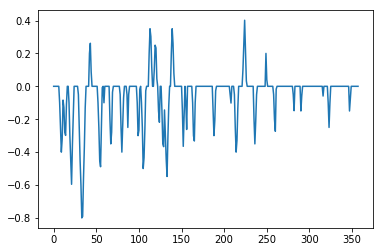

In [52]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

LOG_FILE  = '/Users/tempflip/Desktop/rec/driving_log.csv'
log = []

with open(LOG_FILE, 'r') as f:
    reader = csv.reader(f)
    log = pd.DataFrame([row for row in reader], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

#print(log[['CENTER', 'STEERING']])
plt.plot(log['STEERING'])
#print(log['CENTER'].values)


(358,)
(358, 160, 320, 3)
255.0 0.0


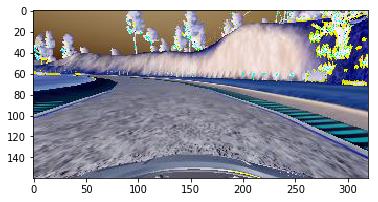

In [53]:
from scipy import misc
im_list = []
for im_file in log['CENTER']:
    im = misc.imread(im_file)
    im_list.append(im)
im_list = np.array(im_list, dtype=np.float32)
#im_list = im_list - 128
#im_list = im_list / 128

steering_targets = np.array(log['STEERING'].values, dtype=np.float32)

print (steering_targets.shape)
print (im_list.shape)
print (np.max(im_list), np.min(im_list))
plt.imshow(im_list[11])

In [56]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Flatten(input_shape=(160, 320, 3)))
#model.add(Dense(100))
model.add(Dense(1))

#print(model.inputs)
#print(model.outputs)

print(im_list.shape, steering_targets.shape)


(358, 160, 320, 3) (358,)


In [59]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(im_list, steering_targets, nb_epoch=100, validation_split=0.2, shuffle=True)


Train on 286 samples, validate on 72 samples
Epoch 1/100
286/286 [==============================] - 0s - loss: 68264365.1802 - acc: 0.0000e+00 - val_loss: 40986673.7778 - val_acc: 0.0000e+00
Epoch 2/100
286/286 [==============================] - 0s - loss: 20092135.5664 - acc: 0.0000e+00 - val_loss: 27876988.8889 - val_acc: 0.0000e+00

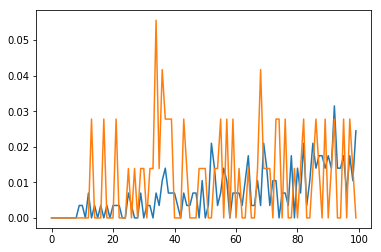

In [61]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [62]:
model.save('my_model.h5')